In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from datetime import datetime
from heapq import heappush,heappop
from collections import Counter,defaultdict
import multiprocessing as mp
import tensorflow as tf
from sklearn.utils import shuffle
import time

PATH="/home/yui/Documents/data/recommender/movieLens20M/rating.csv"
df = pd.read_csv(PATH)
df.head(5)

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [2]:
def findNMatches(df,targetUser,leastCommon=25,minMoviesWatched=50,noRef=25):
    tardf = df[df["userId"]==targetUser]
    u2m = defaultdict(dict)
    valCountsUserId = df["userId"].value_counts()

    for j in range(tardf.shape[0]):
        movieId = tardf.iloc[j]["movieId"]
        u2m[targetUser][movieId] = tardf.iloc[j]["rating"]
    avg = np.array(list(u2m[targetUser].values())).mean()
    u2m[targetUser] = (u2m[targetUser],avg)
    tarSet = set(u2m[targetUser][0])
    # print(tarSet)
    prevId,storeSet,storeDict = 0,set(),dict()
    for i in tqdm(range(df.shape[0])):
        row = df.iloc[i]
        userId = row["userId"]
        if valCountsUserId[userId]<minMoviesWatched:
            continue
        if userId==targetUser:
            continue
        if userId!=prevId:
            if len(tarSet&storeSet)>=leastCommon:
                avg = np.array(list(storeDict.values())).mean()
                u2m[prevId]=(storeDict,avg)
            storeSet,storeDict=set(),dict()
        prevId = userId
        storeSet.add(row["movieId"])
        storeDict[row["movieId"]]=row["rating"]
        if len(u2m)>noRef:
            break
    return u2m


In [3]:
class MF:
    def __init__(self,u2m,K=100,penalty=0.1):
        self.u2m = u2m
        self.penalty = penalty
        self.K = K
        self.allmovies = dict()
        self.mean,i=0,0
        for candidate in u2m:
            for movie in u2m[candidate][0]:
                t,c = self.allmovies.get(movie,(0,0))
                c+=1
                t+=u2m[candidate][0][movie]
                self.allmovies[movie]=(t,c)
                i+=1
                self.mean+=u2m[candidate][0][movie]
        self.mean/=i
        for movie in self.allmovies:
            t,c = self.allmovies[movie]
            self.allmovies[movie] = (t/c,c)
        self.m2id = {key:i for i,key in enumerate(self.allmovies)}
        self.id2m = {i:key for i,key in enumerate(self.allmovies)}
        self.u2id = {key:i for i,key in enumerate(u2m)}
        self.id2u = {i:key for i,key in enumerate(u2m)}
        self.N = len(u2m)
        self.M = len(self.allmovies)

#### Embedding Layers

It is a lookup table, which can convert ids to embedding vector. So we can input user id $x_1\rightarrow i$ and movie id $x_2\rightarrow j$, get their respective vectors $w_i$ and $u_j$, and add their dot product with user bias $b_i$ and movie bias $c_j$ to predict the difference between rating $r_{ij}$ and global mean $\mu$.

$$y = r_{ij}-\mu = w_i^Tu_j + b_i + c_j$$

In [4]:
class nnMF:
    def __init__(self,df,targetUser,K=100,split=0.85,batch_size=16):
        self.u2m = findNMatches(df,targetUser)
        self.mf = MF(self.u2m,K=K)
        tdf = df[df["userId"].isin(list(self.u2m.keys()))]
        self.tdf = shuffle(tdf)
        self.split = split
        self.batch_size = batch_size
        self.prepareData()
        self.getModel()
    def getX1X2Y(self,dataset):
        w = [self.mf.u2id[i] for i in list(dataset['userId'])]
        XW = np.array(w).reshape(-1,1,1)
        u = [self.mf.m2id[i] for i in list(dataset['movieId'])]
        XU = np.array(u).reshape(-1,1,1)
        Y = np.array(dataset['rating'])-self.mf.mean
        return XW,XU,Y
    def prepareData(self):
        trainSet = self.tdf.iloc[:int(self.split*self.tdf.shape[0])]
        testSet = self.tdf.iloc[int(self.split*self.tdf.shape[0]):]
        trainXW,trainXU,trainY = self.getX1X2Y(trainSet)
        testXW,testXU,testY = self.getX1X2Y(testSet)
        train_dataset = tf.data.Dataset.from_tensor_slices(\
            (trainXW,trainXU,trainY))
        self.train_dataset = train_dataset.shuffle(buffer_size=1024)\
                    .batch(self.batch_size)
        val_dataset = tf.data.Dataset.from_tensor_slices(\
            (testXW,testXU,testY))
        self.val_dataset = val_dataset.batch(self.batch_size)
    def getModel(self):
        n1 = tf.keras.Input(shape=(1,))
        m1 = tf.keras.Input(shape=(1,))
        k1n = tf.keras.layers.Embedding(self.mf.N,self.mf.K)(n1)
        k1m = tf.keras.layers.Embedding(self.mf.M,self.mf.K)(m1)
        b = tf.keras.layers.Embedding(self.mf.N,1)(n1)
        c = tf.keras.layers.Embedding(self.mf.M,1)(m1)
        y = tf.multiply(k1n,k1m)
        y = tf.reduce_sum(y,axis=2,keepdims=True)
        y = tf.add_n([y,b,c])
        y = tf.reshape(y,[-1])
        self.model = tf.keras.Model(inputs=[n1,m1],outputs=[y])

In [5]:
mf = nnMF(df,1)

  0%|          | 15441/20000263 [00:01<32:56, 10110.63it/s]


In [6]:
epochs = 500
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
printInterval = 50
trainLosses = []
testLosses = []

for epoch in range(epochs):
    total_train_loss=0
    for i,(x1,x2,y) in enumerate(mf.train_dataset):
        with tf.GradientTape() as tape:
            pred=mf.model([x1,x2],training=True)
            loss = tf.keras.losses.mean_squared_error(y,pred)
            total_train_loss+=tf.reduce_sum(loss)
        grads = tape.gradient(loss,mf.model.trainable_weights)
        opt.apply_gradients(zip(grads,mf.model.trainable_weights))
    
    if epoch%printInterval==0:
        total_val_loss = 0
        for j,(x1,x2,y) in enumerate(mf.val_dataset):
            pred=mf.model([x1,x2],training=False)
            total_val_loss+=tf.reduce_sum(\
                tf.keras.losses.mean_squared_error(y,pred))
        print("Epoch {} Train loss: {:.4f}".format(\
                epoch,float(total_train_loss/(i+1))))
        print("Epoch {} Validation loss: {:.4f}".format(\
                epoch,float(total_val_loss/(j+1))))
        trainLosses.append(total_train_loss/(i+1))
        testLosses.append(total_val_loss/(j+1))

Epoch 0 Train loss: 1.2185
Epoch 0 Validation loss: 1.1052
Epoch 50 Train loss: 0.0077
Epoch 50 Validation loss: 0.8802
Epoch 100 Train loss: 0.0047
Epoch 100 Validation loss: 0.8713
Epoch 150 Train loss: 0.0036
Epoch 150 Validation loss: 0.8679
Epoch 200 Train loss: 0.0031
Epoch 200 Validation loss: 0.8703
Epoch 250 Train loss: 0.0027
Epoch 250 Validation loss: 0.8671
Epoch 300 Train loss: 0.0024
Epoch 300 Validation loss: 0.8640
Epoch 350 Train loss: 0.0023
Epoch 350 Validation loss: 0.8716
Epoch 400 Train loss: 0.0021
Epoch 400 Validation loss: 0.8767
Epoch 450 Train loss: 0.0019
Epoch 450 Validation loss: 0.8757


Text(0, 0.5, 'loss')

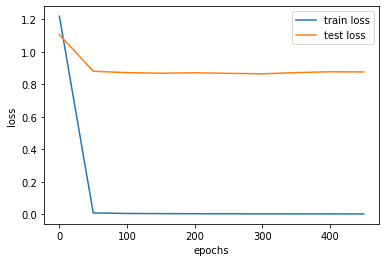

In [7]:
plt.plot(range(0,epochs,printInterval),
         trainLosses,label='train loss')
plt.plot(range(0,epochs,printInterval),
         testLosses,label='test loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

In [8]:
targetUser,limit = 1,100
x1 = np.array([mf.mf.u2id[targetUser]]).reshape(1,1,1)
res = []
for i,movie in enumerate(mf.mf.allmovies):
    x2 = np.array([mf.mf.m2id[movie]]).reshape(1,1,1)
    pred=mf.model([x1,x2],training=False)+mf.mf.mean
    if movie in mf.u2m[targetUser][0]:
        if i<limit:
            print("Movie {}: {} (truth) {:.4f} (pred)".format(\
            movie,mf.u2m[targetUser][0][movie],
            pred[0]))
    else:
        store = -pred.numpy()[0]
        heappush(res,(store,movie))

Movie 2: 3.5 (truth) 3.4731 (pred)
Movie 29: 3.5 (truth) 3.5464 (pred)
Movie 32: 3.5 (truth) 3.6001 (pred)
Movie 47: 3.5 (truth) 3.5910 (pred)
Movie 50: 3.5 (truth) 3.5583 (pred)
Movie 112: 3.5 (truth) 3.4893 (pred)
Movie 151: 4.0 (truth) 3.4752 (pred)
Movie 223: 4.0 (truth) 4.0552 (pred)
Movie 253: 4.0 (truth) 3.9902 (pred)
Movie 260: 4.0 (truth) 3.9916 (pred)
Movie 293: 4.0 (truth) 4.0455 (pred)
Movie 296: 4.0 (truth) 4.0385 (pred)
Movie 318: 4.0 (truth) 4.0178 (pred)
Movie 337: 3.5 (truth) 3.4843 (pred)
Movie 367: 3.5 (truth) 3.0604 (pred)
Movie 541: 4.0 (truth) 4.0087 (pred)
Movie 589: 3.5 (truth) 3.5465 (pred)
Movie 593: 3.5 (truth) 3.5281 (pred)
Movie 653: 3.0 (truth) 3.0210 (pred)
Movie 919: 3.5 (truth) 3.5290 (pred)
Movie 924: 3.5 (truth) 3.4552 (pred)
Movie 1009: 3.5 (truth) 3.4552 (pred)
Movie 1036: 4.0 (truth) 3.9852 (pred)
Movie 1079: 4.0 (truth) 3.9989 (pred)
Movie 1080: 3.5 (truth) 3.4838 (pred)
Movie 1089: 3.5 (truth) 3.5052 (pred)
Movie 1090: 4.0 (truth) 3.9952 (pred)
M

In [9]:
res[:10]

[(-4.556903, 2329),
 (-4.5160446, 1234),
 (-4.350629, 2858),
 (-4.460514, 7361),
 (-4.442555, 6016),
 (-4.204738, 30707),
 (-4.324671, 79132),
 (-4.418446, 1203),
 (-4.4559, 44555),
 (-4.2956815, 527)]